In [21]:
import numpy as np
import matplotlib.pyplot as plt
import random
import itertools
import ProjectPacks as pp
%matplotlib inline

from IPython.display import HTML 
HTML('../style/course.css') #apply general CSS

from scipy.optimize import leastsq
plt.rcParams['figure.figsize'] = (18, 6)  #spreads out plot surface for better visualization

from IPython.display import HTML
HTML('../style/code_toggle.html')

In [22]:
def modfunc(x, u_ant, v_ant):
    """
    Returns a vector containing the values of a 3x3 model exponential matrix with source parameters A0,l0,m0.
    
    INPUTS:
    x               Vector of source parameters.  Amp,l,m= x[0],x[1],x[2]  
    u_ant, v_ant    Value of (u,v)baseline measurements at the sampled (timeslot) points.
    """

    Amp= 1
    l= x[0]
    m= x[1]
    
    model= Amp*np.exp(-2j*np.pi*(u_ant*l+v_ant*m))
    
    model_stream= np.asarray(list(itertools.chain(model[0,1,:], model[0,2,:], model[1,2,:], 
                                                  model[1,0,:], model[2,0,:], model[2,1,:])),dtype=np.complex128)
    ## with t timeslots each
    return model_stream

In [23]:
def modfunc_jac(x,u_ant,v_ant):
    """
    Returns the Hessian and Jacobian corresponding to the function defined by model equation.
    
    INPUTS:
    x               Vector of source parameters.  A,l,m= x[0],x[1],x[2] 
    u_ant, v_ant    Value of (u,v)baseline measurements at the sampled (timeslot) points. use this as a loop
   
    """
    t= u_ant.shape[2]
    Amp= 1
    l= x[0]
    m= x[1]
    
    ## Calculating JHJ explicitly from J
    Psi= -2j*np.pi*(u_ant*l+v_ant*m)
    expPsi= lambda sign: np.exp(sign*Psi)
    
    coeU = -2j*np.pi*Amp*u_ant
    coeV = -2j*np.pi*Amp*v_ant
    ## remember the -(minus) for negative exponents
    
    ## filling up (3,3,300) per baseline row-wise (downwards)
    #JkA= np.asarray(list(itertools.chain(expPsi(-1)[0,1,:], expPsi(-1)[0,2,:], expPsi(-1)[1,2,:])),dtype=np.complex128)
    
    Jkl= np.asarray(list(itertools.chain((coeU*expPsi(1))[0,1,:], (coeU*expPsi(1))[0,2,:], 
                                         (coeU*expPsi(1))[1,2,:], (coeU*expPsi(1))[1,0,:], 
                                         (coeU*expPsi(1))[2,0,:], (coeU*expPsi(1))[2,1,:])),
                    dtype=np.complex64)
    
    Jkm= np.asarray(list(itertools.chain((coeV*expPsi(1))[0,1,:], (coeV*expPsi(1))[0,2,:], 
                                         (coeV*expPsi(1))[1,2,:], (coeV*expPsi(1))[1,0,:], 
                                         (coeV*expPsi(1))[2,0,:], (coeV*expPsi(1))[2,1,:])),
                    dtype=np.complex64)
   
    Jk= np.empty((len(Jkl),x.shape[0]),dtype=np.complex64)
    
    #Jk[:,0]= JkA
    Jk[:,0]= Jkl
    Jk[:,1]= Jkm      
    
    Jh= Jk.conj().T ## Hermitian of J
    
    Complete= Jh.dot(Jk)
    
#     # using Analytic JHJ
#     Complete= np.zeros((3,3), dtype=np.complex128)
#     for i in range(t):

#         U= u_ant[:,:,i]
#         V= v_ant[:,:,i]

#         sumU,sqsumU= np.sum(np.triu(U,1)),np.sum(np.square(np.triu(U,1)))
#         sumV, sqsumV= np.sum(np.triu(V,1)),np.sum(np.square(np.triu(V,1)))
#         sumUV= np.sum(np.multiply(np.triu(U,1),np.triu(V,1)))

#         ## Packing into Analytic JHJ
#         JHJ= np.array([[3, -2j*np.pi*Amp*sumU, -2j*np.pi*Amp*sumV],
#                   [2j*np.pi*Amp*sumU, np.square(2*np.pi*Amp)*sqsumU, np.square(2*np.pi*Amp)*sumUV],
#                   [2j*np.pi*Amp*sumV, np.square(2*np.pi*Amp)*sumUV, np.square(2*np.pi*Amp)*sqsumV]],dtype=np.complex128)


#         Complete += JHJ
    
    return Jh,Complete


In [24]:
def modfunc_res(x, u_ant, v_ant, data):
    """
    Returns a vector containing the residual values over timeslots.
    
    INPUTS:
    data            Vector of measured values.
    u_ant, v_ant    Value of (u,v)baseline measurements at the sampled (timeslot) points.
    x               Vector of source parameters.  A,l,m= x[0],x[1],x[2]    
    """
    
    residual= data - modfunc(x, u_ant, v_ant)
    
    return residual

In [89]:
## Setting up for test using above function
###################RANDOM_X_CON_M###########################

## Choose number of timeslots
timeslots= 100
Amp_no,l_no,m_no,ut,vt,SNum,ArNum,arrayHxpos=pp.formatSParams('Array_Profile.txt','Field_Profile.txt',td=timeslots)

t = np.arange(0, 5, 5/timeslots)          #The points at which we will be taking our "measurements"
noise = 0.000*np.random.normal(size=(2*t.shape[0])*len(ut)) #A noise vector used to manufacture "real" measurements.

x_true = np.array(np.radians([0.4, 0.5]))          #The true (starting) values of our parameter vector (for alg).
x_con = np.array(np.radians([0.5, 0.5]))

x_start= x_con.copy()

d = modfunc(x_true, ut, vt) + noise #Our "observed" data, contructed from our true parameter values and the noise vector.
m = modfunc(x_con, ut, vt)              #Our fitted function using the initial guess parameters.
r = modfunc_res(x_con, ut, vt, d)

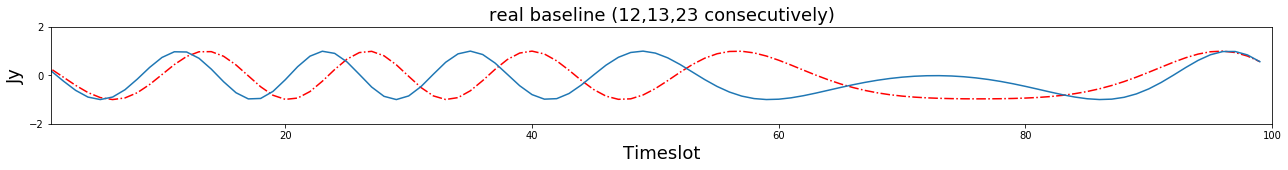

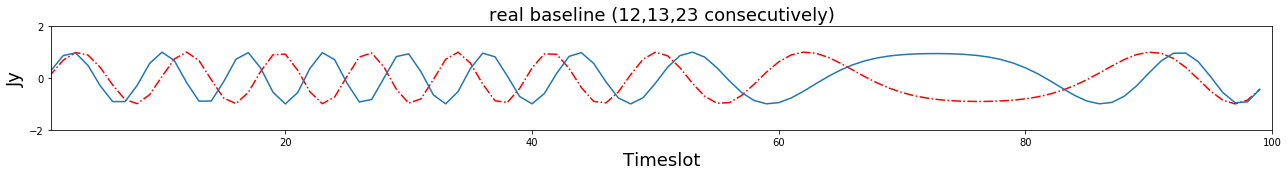

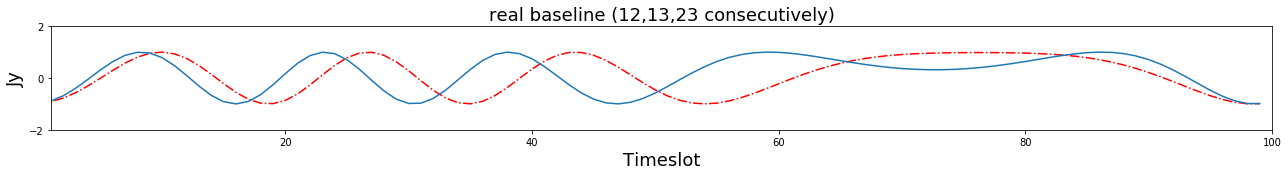

In [90]:
subps=["311","312","312"]

plt.figure()
for j in range(len(ut)):
    ax = plt.subplot(subps[j])
    ax.set_title("real baseline (12,13,23 consecutively)", fontsize=18)
    ax.plot(range(timeslots),d[j*t.shape[0]:(j+1)*t.shape[0]].real,'r-.')
    ax.plot(range(timeslots),m[j*t.shape[0]:(j+1)*t.shape[0]].real)
    ax.set_xlabel("Timeslot", fontsize=18)
    ax.set_ylabel("Jy", fontsize=18)
    ax.set_xlim([1,t.shape[0]])
    y_t = ax.get_yticks()
    y_t = y_t[::2]
    ax.set_yticks(y_t)

    plt.tight_layout()
    plt.show()

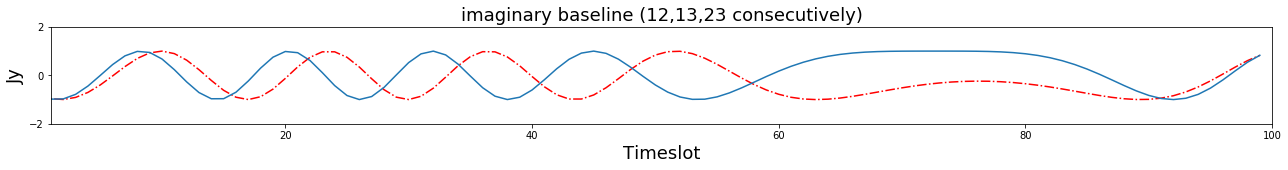

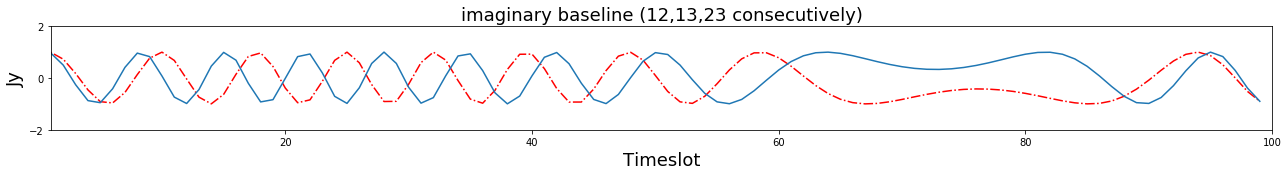

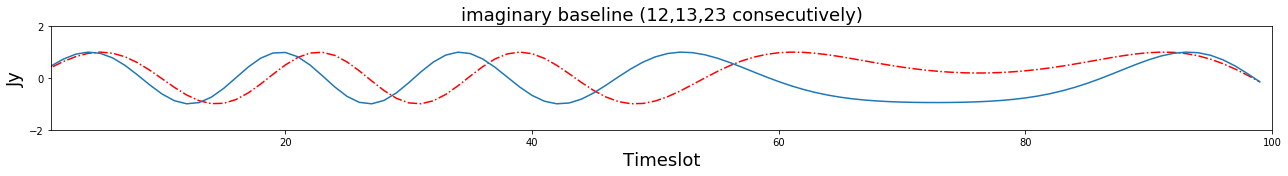

In [91]:
subps=["311","312","312"]

plt.figure()
for j in range(len(ut)):
    ax = plt.subplot(subps[j])
    ax.set_title("imaginary baseline (12,13,23 consecutively)", fontsize=18)
    ax.plot(range(timeslots),d[j*t.shape[0]:(j+1)*t.shape[0]].imag,'r-.')
    ax.plot(range(timeslots),m[j*t.shape[0]:(j+1)*t.shape[0]].imag)
    ax.set_xlabel("Timeslot", fontsize=18)
    ax.set_ylabel("Jy", fontsize=18)
    ax.set_xlim([1,t.shape[0]])
    y_t = ax.get_yticks()
    y_t = y_t[::2]
    ax.set_yticks(y_t)

    plt.tight_layout()
    plt.show()

In [92]:
## trying out real case first
def levenberg_marquardt(data, u_ant, v_ant, x, r_func, j_func, maxit=100, lamda=1, K=10, eps1=1e-6, eps2=1e-6):
    """
    Returns a vector containing the optimal parameter values found by the algorithm.
    
    INPUTS:
    d         Vector of measured values.
    t         Value of independent variable at the sampled points. (300)
    x         Vector of parameters. (1,3)
    r_func    Function which generates the residual vector. (1,900)
    j_func    Function which generates the (Conjugate of) Jacobian & the Hessian. (3,900) & (3,3) 
    maxiter   Maximum number of iterations.
    lamda     Initial value of tuning parameter.
    K         Initial value of retuning factor.
    eps1      First tolerance parameter - triggers when residual is below this number.
    eps2      Second tolerance parameter - triggers when relative changes to the parameter
              vector are below this number.
    """
    
    #Initialises some important values and stores the original lamda value.
    
    r = r_func(x, u_ant, v_ant, data)
    print("Shape of residual vec: ", np.shape(r))
    old_chi = np.linalg.norm(r)
    olamda = lamda
    it = 0
    
    chiplot=[]
    chiplot.append(old_chi)
    
    solpath= x
    
    while True:
        
        #Heavy lifting portion of the algorithm. Computes the parameter update.
        #This is just the implementation of the mathmatical update rule.
        JH,JHJ = j_func(x,u_ant,v_ant)
        
        JHJdiag = np.diag(np.diag(JHJ))
        #this says there is a different D for each timeslot
#         lamda = 1 if (it%2==0) else 0
        JHJinv= np.linalg.pinv(JHJ+lamda*JHJdiag)
        JHr = JH.dot(r)
        
        delta_x = JHJinv.dot(JHr)
        x += delta_x.real
        
        solpath= np.vstack((solpath,x))        
        
        #Convergence tests. If a solution has been found, returns the result.
        #The chi value is the norm of the residual and is used to determine
        #whether the solution is improving. If the chi value is sufficiently 
        #small, the function terminates. The second test checks to see whether
        #or not the solution is improving, and terminates if it isn't.
        
        r = r_func(x, u_ant, v_ant, data)
        new_chi = np.linalg.norm(r)
        chiplot.append(new_chi)
        
        if new_chi < eps1:
            return x,chiplot,solpath
        elif np.linalg.norm(delta_x.real) < eps2*(np.linalg.norm(x) + eps2):
            return x,chiplot,solpath
        
        #Tuning stage. If the parameter update was good, continue and restore lamda.
        #If the update was bad, scale lamda by K and revert last update.
        
        if new_chi > old_chi:
            x -= delta_x.real
            lamda = lamda*K
        else:
            old_chi = new_chi
            lamda = olamda
            
        #If the number of iterations grows too large, return the last value of x.
        
        it += 1
            
        if it >= maxit:
            return x,chiplot,solpath


In [93]:
solved_x,cplot,spath = levenberg_marquardt(d,ut,vt,x_con,modfunc_res,modfunc_jac)
print("solved x: ", solved_x)
print("true x: ", x_true)
print("model x: ",  x_start) #got from up there

Shape of residual vec:  (600,)
solved x:  [ 0.00698133  0.00872665]
true x:  [ 0.00698132  0.00872665]
model x:  [ 0.00872665  0.00872665]


In [94]:
print(spath)
print(np.shape(spath))
print(spath[:,1])

[[ 0.00866007  0.00872665]
 [ 0.00866007  0.00872665]
 [ 0.00857782  0.00872665]
 [ 0.00847439  0.00872665]
 [ 0.0083424   0.00872665]
 [ 0.00817318  0.00872665]
 [ 0.00796031  0.00872665]
 [ 0.00770993  0.00872665]
 [ 0.00745583  0.00872665]
 [ 0.00725157  0.00872665]
 [ 0.00712279  0.00872665]
 [ 0.00705298  0.00872665]
 [ 0.00701727  0.00872665]
 [ 0.00699931  0.00872665]
 [ 0.00699031  0.00872665]
 [ 0.00698582  0.00872665]
 [ 0.00698357  0.00872665]
 [ 0.00698244  0.00872665]
 [ 0.00698188  0.00872665]
 [ 0.0069816   0.00872665]
 [ 0.00698146  0.00872665]
 [ 0.00698139  0.00872665]
 [ 0.00698135  0.00872665]
 [ 0.00698133  0.00872665]
 [ 0.00698133  0.00872665]]
(25, 2)
[ 0.00872665  0.00872665  0.00872665  0.00872665  0.00872665  0.00872665
  0.00872665  0.00872665  0.00872665  0.00872665  0.00872665  0.00872665
  0.00872665  0.00872665  0.00872665  0.00872665  0.00872665  0.00872665
  0.00872665  0.00872665  0.00872665  0.00872665  0.00872665  0.00872665
  0.00872665]


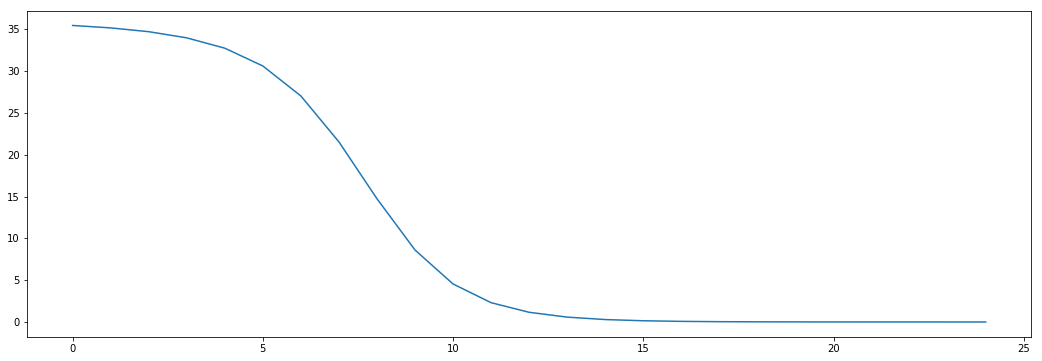

In [95]:
plt.plot(cplot)
plt.show()

In [103]:
L= np.radians(np.arange(-1,1,2/200))
M= np.radians(np.arange(-1,1,2/200))

rr= np.empty((200,200))

for b in range(200):
    for a in range(200):
        
        x_r= [L[a],M[b]]
        rr[a,b]= np.square(np.linalg.norm(modfunc_res(x_r,ut,vt,d)))

In [104]:
print(L.max(),L.min(),M.max(),M.min(),rr.max(),rr.min())

0.0172787595947 -0.0174532925199 0.0172787595947 -0.0174532925199 1469.90097429 9.21630202818e-25


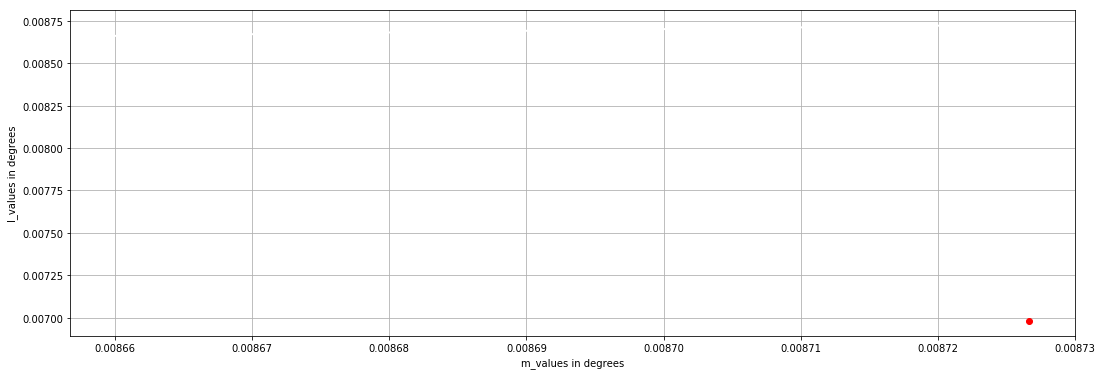

In [107]:
#plt.imshow(rr)
plt.plot(spath[:][1],spath[:][0], 'w',lw=2)
plt.plot(x_true[1],x_true[0],'ro',lw=1)
#plt.colorbar()
plt.grid()
plt.xlabel("m_values in degrees")
plt.ylabel("l_values in degrees")
plt.show()

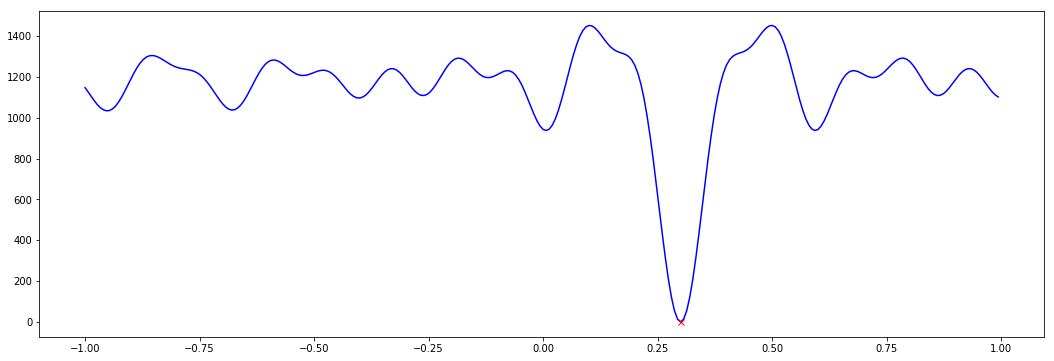

In [75]:
plt.plot(L*180/np.pi,rr[:,225], 'b', x_true[0]*180/np.pi,[0],'rx')
plt.show()

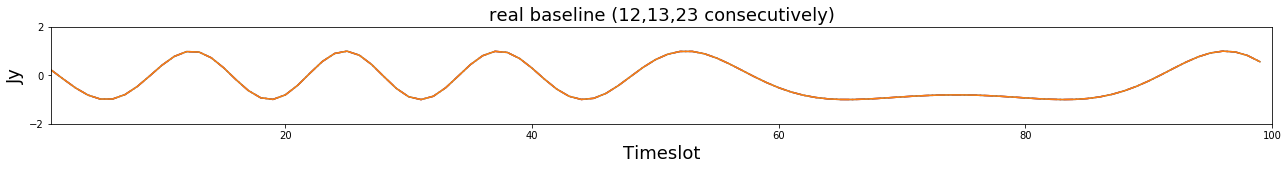

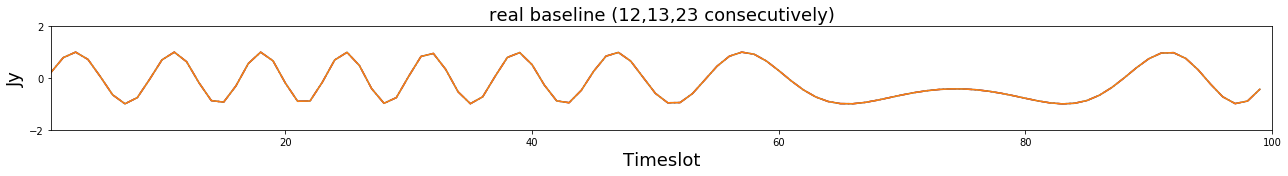

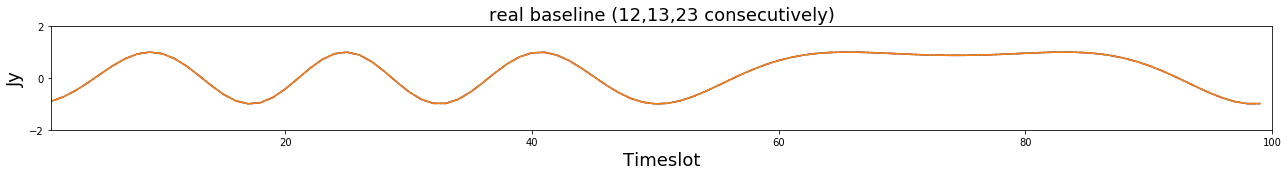

In [38]:
subps=["311","312","312"]

plt.figure()
for j in range(len(ut)):
    ax = plt.subplot(subps[j])
    ax.set_title("real baseline (12,13,23 consecutively)", fontsize=18)
    ax.plot(range(timeslots),d[j*t.shape[0]:(j+1)*t.shape[0]].real,'r-.')
    ax.plot(range(timeslots),modfunc(solved_x,ut,vt)[j*t.shape[0]:(j+1)*t.shape[0]].real)
    ax.plot(range(timeslots),modfunc(x_true,ut,vt)[j*t.shape[0]:(j+1)*t.shape[0]].real)
    ax.set_xlabel("Timeslot", fontsize=18)
    ax.set_ylabel("Jy", fontsize=18)
    ax.set_xlim([1,t.shape[0]])
    y_t = ax.get_yticks()
    y_t = y_t[::2]
    ax.set_yticks(y_t)

    plt.tight_layout()
    plt.show()


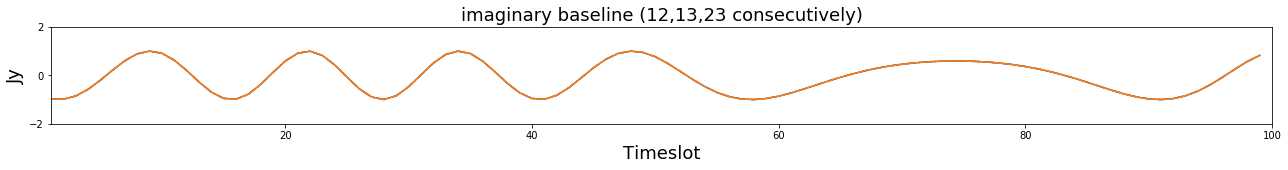

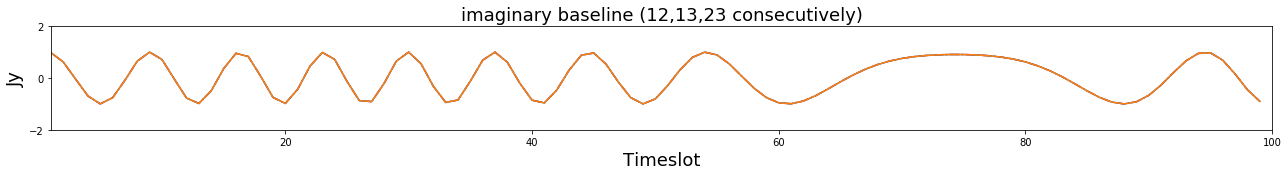

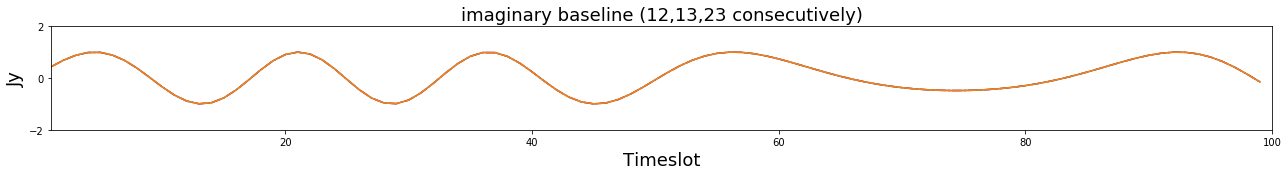

In [41]:
subps=["311","312","312"]

plt.figure()
for j in range(len(ut)):
    ax = plt.subplot(subps[j])
    ax.set_title("imaginary baseline (12,13,23 consecutively)", fontsize=18)
    ax.plot(range(timeslots),d[j*t.shape[0]:(j+1)*t.shape[0]].imag,'r-.')
    ax.plot(range(timeslots),modfunc(solved_x,ut,vt)[j*t.shape[0]:(j+1)*t.shape[0]].imag)
    ax.plot(range(timeslots),modfunc(x_true,ut,vt)[j*t.shape[0]:(j+1)*t.shape[0]].imag)
    ax.set_xlabel("Timeslot", fontsize=18)
    ax.set_ylabel("Jy", fontsize=18)
    ax.set_xlim([1,t.shape[0]])
    y_t = ax.get_yticks()
    y_t = y_t[::2]
    ax.set_yticks(y_t)

    plt.tight_layout()
    plt.show()

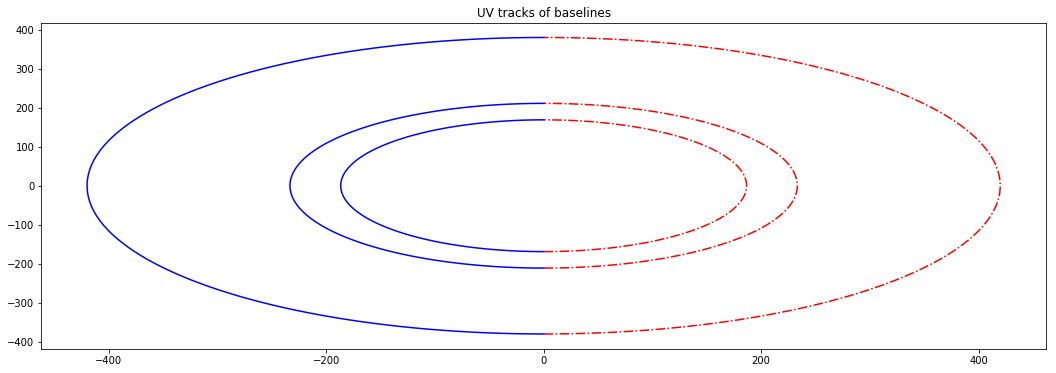

In [42]:
for k in range(ArNum):
    for i in range(k,ArNum):
        plt.plot(ut[k][i],vt[k][i],"r-.", ut[i][k],vt[i][k],"b-")
        
plt.title("UV tracks of baselines")
plt.show()